In [1]:
from src.eda_vector import *
from src.lda_model import *
from src.model import *
from src.classifier import *
from src.helpers import *
from imblearn.over_sampling import SMOTE
import pandas as pd

### Load data

In [2]:
# load data, train, test, split
X_train, X_test, y_train, y_test = get_data_wrapper(sample=True, samp_size=0.01)

/Users/jonleckie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/jonleckie/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3427: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


### Vectorize and balance

In [3]:
# vectorizing process
custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
                'trump', 'clinton', 'donald', 'donald trump', 'donaldtrump', 'says', 'hillary', 'hillaryclinton',
                'hillary clinton', 'realdonaldtrump', 'would', 'let', 'video', 'like']

# custom_stops = ['https', 'rt', 'co', 'amp', 'via', 'go', 'get', 'said', 'say', 'news', 'new', 'make', 'want', 
#                 'says', 'would', 'let', 'video', 'like']

# fit vectorizer, add stop words, return vocab
vectors = EDA_vec(X_train, y_train)
vectors.add_stop_words(custom_stops)
vocab, fit_mat = vectors.vectorize(vec_type='tfidf', min_df=0.0001)

# transform training and testing data 
matrix = fit_mat.transform(X_train)
matrix_test = fit_mat.transform(X_test)

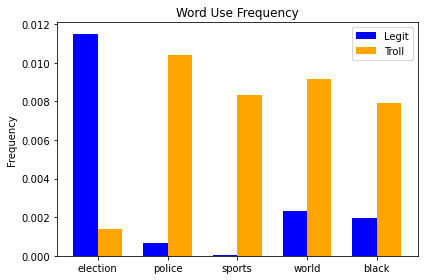

In [4]:
vectors.word_freq()
vectors.chart_word_freq(low_words=0, high_words=5)

### Random forest classifier

In [6]:
# balance count vectorized data for training
bal_matrix, bal_y_train = SMOTE().fit_resample(matrix, y_train) 

Balanced model:

Random Forest Scores -- w/out LDA
accuracy = 0.8300754432626753
oob = 0.8696743360714144
recall = 0.8024336283185841
precision = 0.26667063461498064
f_one = 0.40030798177336535


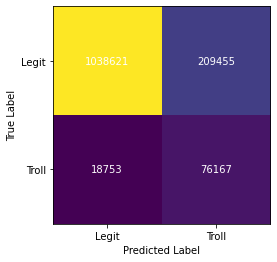

In [7]:
# random forest (without LDA) -- balanced fit, unbalanced predict
forest = RandForest(n_estimators=150, max_depth=150, max_leaf=None, 
                    max_features='log2', class_weight='balanced')
forest.fit(bal_matrix, bal_y_train)
probas, y_hat = forest.predict(matrix_test, thresh=0.542)
forest.score(y_test, y_hat)
print('Random Forest Scores -- w/out LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

25% threshold

Random Forest Scores -- w/out LDA
accuracy = 0.5184252224131718
oob = 0.8696743360714144
recall = 0.9717973029919933
precision = 0.12527586548764869
f_one = 0.22194098207615376


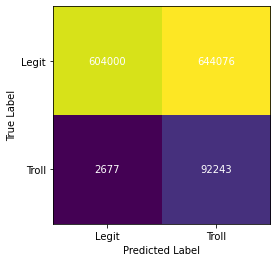

In [8]:
probas, y_hat = forest.predict(matrix_test, thresh=0.25)
forest.score(y_test, y_hat)
print('Random Forest Scores -- w/out LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

75% threshold:

Random Forest Scores -- w/out LDA
accuracy = 0.950725839838689
oob = 0.8696743360714144
recall = 0.3208280657395702
precision = 0.9468921986256646
f_one = 0.4792691275643094


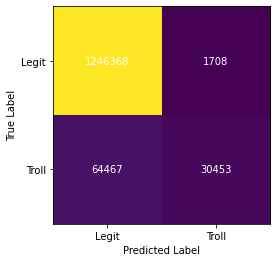

In [9]:
probas, y_hat = forest.predict(matrix_test, thresh=0.75)
forest.score(y_test, y_hat)
print('Random Forest Scores -- w/out LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

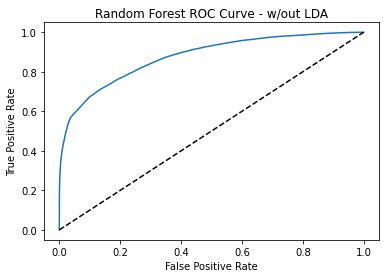

In [10]:
thresh_nolda = plot_roc_curve(matrix_test, y_test, lda=False) # wihtout LDA

In [11]:
roc_thresholds = pd.DataFrame({'fpr': thresh_nolda[0], 'tpr': thresh_nolda[1], 'thresh': thresh_nolda[2]})

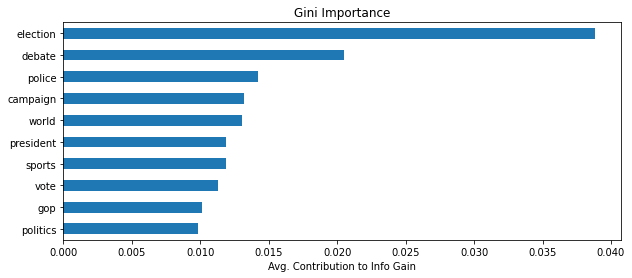

In [13]:
forest.chart_gini_import(features=10, vocab=vocab)

### LDA model

In [57]:
# # fit LDA model on training data
lda = LDA_model(topics=5)
lda.fit(matrix, y_train, vocab)
lda.phi() # to evaluate coherence score
theta = lda.theta()

# get test theta for random forest evaluation
theta_test = lda.test_theta(matrix_test)

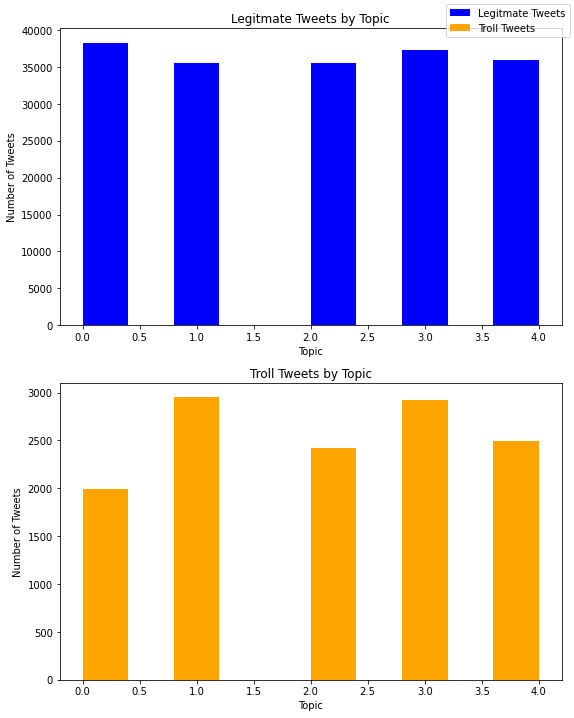

In [58]:
# get topic liklihoods by class
lda.topic_likelihood()
lda.plot_topics_by_class()

In [61]:
# balance count vectorized data for training
bal_theta, bal_y_train = SMOTE().fit_resample(theta, y_train) 

Random Forest Scores -- with LDA
accuracy = 0.8920837933995829
oob = 0.919184046294625
recall = 0.2957481794691097
precision = 0.23763684409211022
f_one = 0.263526949241235


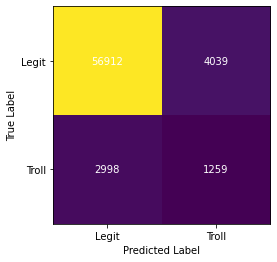

In [62]:
# random forest (with LDA)
forest = RandForest(n_estimators=150, max_depth=150, max_leaf=None, 
                    max_features=theta.shape[1], class_weight=None)
forest.fit(bal_theta, bal_y_train)
probas, y_hat = forest.predict(theta_test, thresh=.542)
forest.score(y_test, y_hat)
print('Random Forest Scores -- with LDA')
print(f'accuracy = {forest.acc}')
print(f'oob = {forest.oob}')
print(f'recall = {forest.recall}')
print(f'precision = {forest.precision}')
print(f'f_one = {forest.f_one}')
forest.plot_confusion()

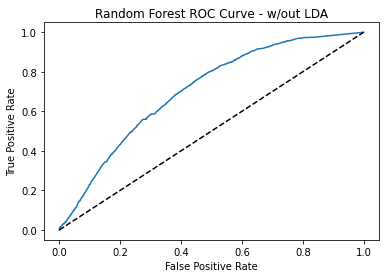

In [63]:
thresh_lda = plot_roc_curve(theta_test, y_test, lda=False) # wihtout LDA

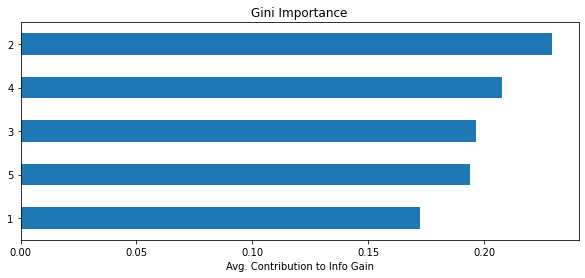

In [64]:
forest.chart_gini_import(features=-1)

### Misclassifications

In [ ]:
def get_misses(y_hat, y_test, X_test):
    df = pd.DataFrame({'text': X_test, 'predicted': y_hat, 'actual': y_test})
    df = df[df['predicted'] != df['actual']]
    false_pos = df[df['predicted'] == 1]
    false_neg = df[df['predicted'] == 0]
    return false_pos, false_neg

In [ ]:
falses_pos, false_neg = get_misses(y_hat, y_test, X_test)

In [104]:
false_pos = pd.read_csv('false_positives_tfidf.csv')
false_neg = pd.read_csv('false_negative_tfidf.csv')

In [115]:
all_misses = pd.concat([false_pos, false_neg])

In [29]:
all_misses['actual'].value_counts()

0    243780
1     17049
Name: actual, dtype: int64